# Predicting the Severity of Vehicle Accidents in Seattle.

## Table of Content
* [Introduction](#introduction)
* [Exploratory Data Analysis](#EDA)
* [Data Preprocessing](#data)
* [Machine Learning Models](#ML)
* [Model Evaluation](#ME)
* [Discussion](#discuss)
* [Policy Recommendation](#policy)
* [Conclusion](#conclude)

# Introduction <a name="introduction"></a>

A comprehensive study on how the risk factors associated with car accidents predict its severity should be of interest to parties involved. These include private citizens who bear the pain of the accidents; the cooperation and State government who bear the loss in productivity as a result of road accidents; and insurance companies that provide cover for road users. This project tries to fill this gap. Using data from road accidents in Seattle, I predict road accident severity - when accidents result in property damage or causing injuries - by considering some of the risk factors discussed in the World Health Organization's accident report and other factors provided by the police recorded data on road accidents. The Washington State Department of Transport (WSDOT) stated that the common causes of accident specific to Seattle are speeding, intoxication, following cars too closely, defective equipment, poor vehicle maintenance and failure to yield right of way. The dataset we use to create a predictive model should measure these factors to a good extent to enable the algorithm learn and predict car accidents in out-of-sample data.

In this notebook, I will introduce and explore the Seattle Department of Transport (SDOT) data, discuss the machine learning models implemented in the analysis, conduct tests on the accuracy of the models and recommend the best predictior of road accident severity. Lastly, I provide some policy recommendations based on findings and conclude.   *(Note - This is the code notebook of the project. The full report can be found in the capstone folder.)*

In [ ]:
# Load the required packages.
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import  f_regression
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Loading the dataset 
df = pd.read_csv('Data-Collisions.csv')

In [4]:
# Display the first five rows of the dataset
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [5]:
# Show all columns in the dataset and the dimension of the accident dataset
print(df.columns)
print('The Dimension of the dataset is ', df.shape)

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')
The Dimension of the dataset is  (194673, 38)


# Exploratory Data Analysis <a name="EDA"></a>

In the exploration, I will discuss some of the pertinent features that measure the risk factors suggested by the World Health Organisation (WHO) and understand how they interact to determine accident severity. It is important to understand that the target variable is whether an accident resulted in the destruction of property or cause injury to a person. We expect the factors that determine these closely related outcomes to involve interaction between the relevant features. It is also worth noting that most of the controls are categorical, therefore, the most appropriate way to have a first view of the data is using bar charts.

In [6]:
# Show the description of the accient severity labels.
df.groupby(['SEVERITYCODE'])['SEVERITYDESC'].value_counts(normalize=True) 

SEVERITYCODE  SEVERITYDESC                  
1             Property Damage Only Collision    1.0
2             Injury Collision                  1.0
Name: SEVERITYDESC, dtype: float64

In [7]:
# Display the weather conditions in the dataset.
df.groupby(['SEVERITYCODE']).WEATHER.value_counts()

SEVERITYCODE  WEATHER                 
1             Clear                       75295
              Raining                     21969
              Overcast                    18969
              Unknown                     14275
              Snowing                       736
              Other                         716
              Fog/Smog/Smoke                382
              Sleet/Hail/Freezing Rain       85
              Blowing Sand/Dirt              41
              Severe Crosswind               18
              Partly Cloudy                   2
2             Clear                       35840
              Raining                     11176
              Overcast                     8745
              Unknown                       816
              Fog/Smog/Smoke                187
              Snowing                       171
              Other                         116
              Sleet/Hail/Freezing Rain       28
              Blowing Sand/Dirt              15
 

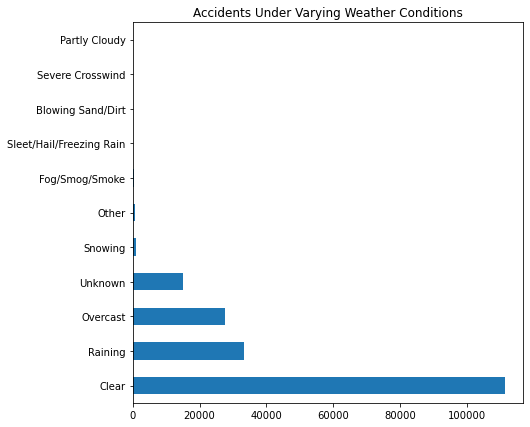

In [8]:
# Plot the distribution of weather type in the dataset
df['WEATHER'].value_counts().plot(kind='barh', figsize = (7, 7))
plt.title('Accidents Under Varying Weather Conditions')
plt.savefig('weather.jpg', bbox_inches = 'tight')

In [9]:
# Reclassify 'under the influence' (UNDERINFL) variable from 'N', 'Y' to 0, 1.
df['UNDERINFL'].value_counts()
df['UNDERINFL'].replace(to_replace = ['N', 'Y'], value = [0, 1], inplace = True)
df['UNDERINFL'] = pd.to_numeric(df['UNDERINFL'], errors='coerce')
df = df.dropna(subset=['UNDERINFL'])
df['UNDERINFL'] = df['UNDERINFL'].dropna()
df['UNDERINFL'] = df['UNDERINFL'].astype(int)

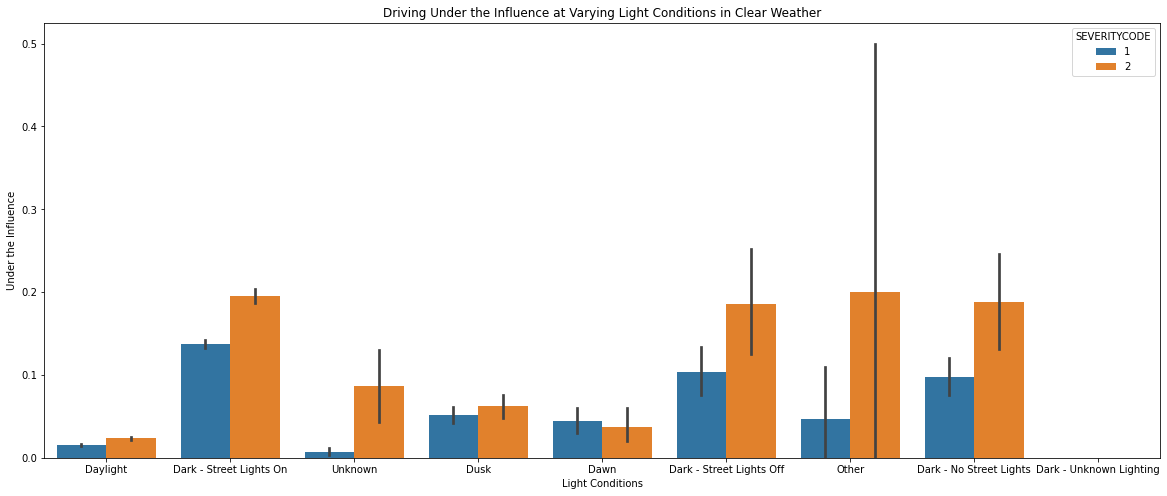

In [10]:
# Generate a plot Severity code by light condition (LIGHTCOND) and under the influence (UNDERINFL) in clear weather
plt.figure(figsize=(20,8))
g = sns.barplot(x='LIGHTCOND', y='UNDERINFL', hue='SEVERITYCODE', data = df[df['WEATHER']=='Clear'])
#plt.show()
plt.title('Driving Under the Influence at Varying Light Conditions in Clear Weather')
plt.ylabel('Under the Influence')
plt.xlabel('Light Conditions')
plt.savefig('li_un_wet.jpg', bbox_inches = 'tight')

In [11]:
# Transform label of 'speeding' from string to numerical.
df['SPEEDING'] = df['SPEEDING'].fillna('N')
df['SPEEDING'].replace(to_replace = ['N', 'Y'], value = [0, 1], inplace = True)

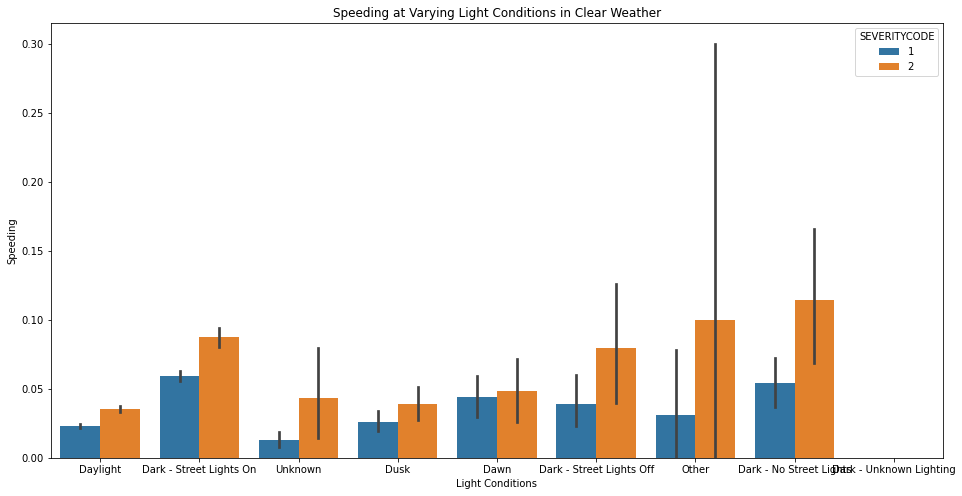

In [12]:
# Plot accidents types by speeding under varying light conditions.
plt.figure(figsize=(16,8))
g = sns.barplot(x='LIGHTCOND', y='SPEEDING', hue='SEVERITYCODE', data = df[df['WEATHER']=='Clear'])
plt.title('Speeding at Varying Light Conditions in Clear Weather')
plt.ylabel('Speeding')
plt.xlabel('Light Conditions')
#plt.show()
plt.savefig('li_sp_wet.jpg', bbox_inches = 'tight')

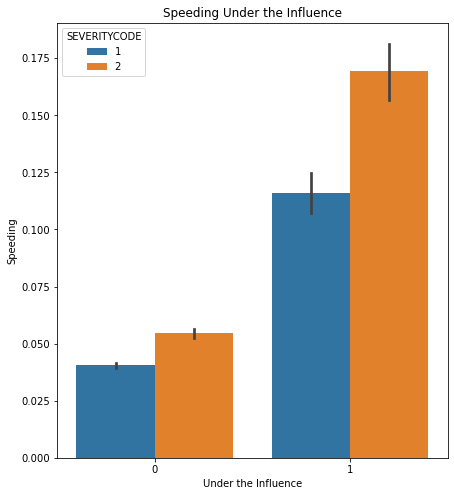

In [13]:
# plot accident severity by speeding under the influence of psychoactive substances.
plt.figure(figsize=(7,8))
g = sns.barplot(x='UNDERINFL', y='SPEEDING', hue = 'SEVERITYCODE', data = df)
plt.title('Speeding Under the Influence')
plt.ylabel('Speeding')
plt.xlabel('Under the Influence')
#plt.show()
plt.savefig('un_sp_sev.jpg', bbox_inches = 'tight')

<Figure size 432x504 with 0 Axes>

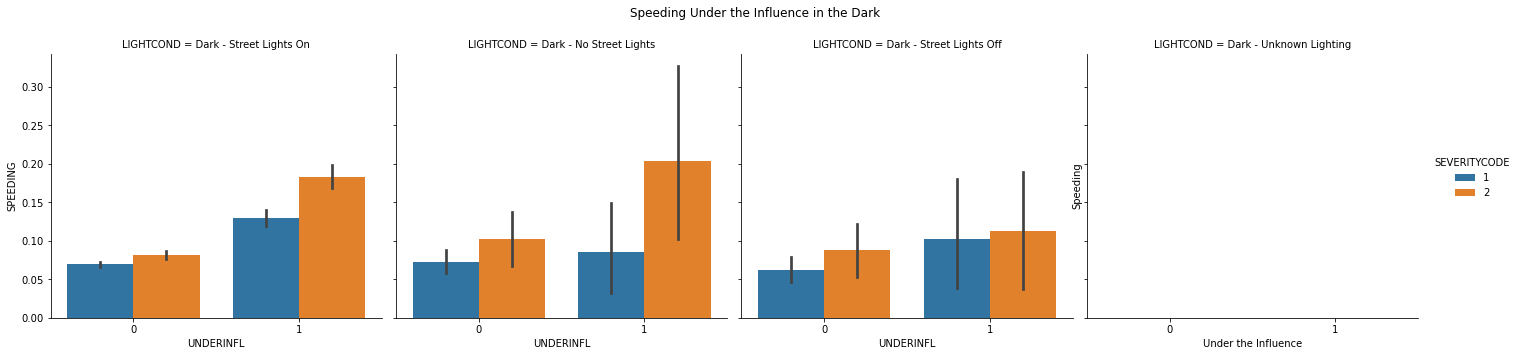

In [14]:
# Show plot of speeding under the influence of psychoactive substances in the dark
plt.figure(figsize=(6,7))
g = sns.catplot(x='UNDERINFL', y='SPEEDING', hue='SEVERITYCODE', col='LIGHTCOND', kind='bar', data = df[df['LIGHTCOND'].str.contains('Dark')==True])
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Speeding Under the Influence in the Dark')
plt.xlabel('Under the Influence')
plt.ylabel('Speeding')
#plt.show()
plt.savefig('un_sp_sev_lig.jpg', bbox_inches = 'tight')

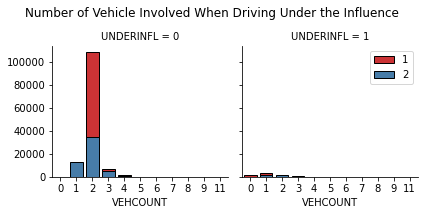

In [15]:
# Plot the distribution of vehicles involved by accident severity and under the influence.
bins = np.linspace(df.VEHCOUNT.min(), df.VEHCOUNT.max(), 10)
g = sns.FacetGrid(df, col="UNDERINFL", hue='SEVERITYCODE', palette="Set1", col_wrap=2)
g.map(sns.countplot, 'VEHCOUNT', ec="k")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Number of Vehicle Involved When Driving Under the Influence')
g.axes[-1].legend()
#plt.show()
plt.savefig('un_sev_hist.jpg', bbox_inches = 'tight')

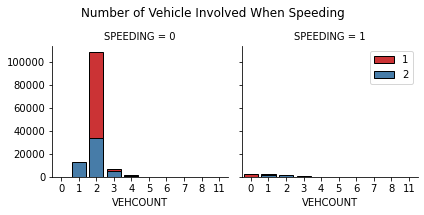

In [16]:
# Plot the distribution of vehicles involved by accident severity and speeding.
bins = np.linspace(df.VEHCOUNT.min(), df.VEHCOUNT.max(), 10)
g = sns.FacetGrid(df, col="SPEEDING", hue='SEVERITYCODE', palette="Set1", col_wrap=2)
g.map(sns.countplot, 'VEHCOUNT', ec="k")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Number of Vehicle Involved When Speeding')
g.axes[-1].legend()
#plt.show()
plt.savefig('sp_sev_hist.jpg', bbox_inches = 'tight')

## Data Preprocessing <a name="data"></a>

This section discusses the transformation techniques applied to the categorical features in the dataset. I use three methods of categorical variable encoding that best suits the feature based on the number of levels in the variable. The methods executed as follows :-

In [17]:
# Select important features to predict the severity of accidents. 
col_df = df[['SEVERITYCODE', 'SEVERITYDESC', 'LOCATION', 'ADDRTYPE', 'COLLISIONTYPE', 'PERSONCOUNT', 'VEHCOUNT', 'JUNCTIONTYPE', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING', 'ST_COLDESC', 'HITPARKEDCAR']]
col_df.head()

,SEVERITYCODE,SEVERITYDESC,LOCATION,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,VEHCOUNT,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,ST_COLDESC,HITPARKEDCAR
0,2,Injury Collision,5TH AVE NE AND NE 103RD ST,Intersection,Angles,2,2,At Intersection (intersection related),0,Overcast,Wet,Daylight,0,Entering at angle,N
1,1,Property Damage Only Collision,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,Block,Sideswipe,2,2,Mid-Block (not related to intersection),0,Raining,Wet,Dark - Street Lights On,0,From same direction - both going straight - bo...,N
2,1,Property Damage Only Collision,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,Block,Parked Car,4,3,Mid-Block (not related to intersection),0,Overcast,Dry,Daylight,0,One parked--one moving,N
3,1,Property Damage Only Collision,2ND AVE BETWEEN MARION ST AND MADISON ST,Block,Other,3,3,Mid-Block (not related to intersection),0,Clear,Dry,Daylight,0,From same direction - all others,N
4,2,Injury Collision,SWIFT AVE S AND SWIFT AV OFF RP,Intersection,Angles,2,2,At Intersection (intersection related),0,Raining,Wet,Daylight,0,Entering at angle,N


In [18]:
# Standardize the target from vales [2,1] to [1, 0] dummy. 
col_df['SEVERITYCODE'].replace(to_replace = [2, 1], value = [1, 0], inplace =True)
col_df.head()

,SEVERITYCODE,SEVERITYDESC,LOCATION,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,VEHCOUNT,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,ST_COLDESC,HITPARKEDCAR
0,1,Injury Collision,5TH AVE NE AND NE 103RD ST,Intersection,Angles,2,2,At Intersection (intersection related),0,Overcast,Wet,Daylight,0,Entering at angle,N
1,0,Property Damage Only Collision,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,Block,Sideswipe,2,2,Mid-Block (not related to intersection),0,Raining,Wet,Dark - Street Lights On,0,From same direction - both going straight - bo...,N
2,0,Property Damage Only Collision,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,Block,Parked Car,4,3,Mid-Block (not related to intersection),0,Overcast,Dry,Daylight,0,One parked--one moving,N
3,0,Property Damage Only Collision,2ND AVE BETWEEN MARION ST AND MADISON ST,Block,Other,3,3,Mid-Block (not related to intersection),0,Clear,Dry,Daylight,0,From same direction - all others,N
4,1,Injury Collision,SWIFT AVE S AND SWIFT AV OFF RP,Intersection,Angles,2,2,At Intersection (intersection related),0,Raining,Wet,Daylight,0,Entering at angle,N


In [19]:
# One-hot code to create dummy variables for address type where accidents took place (ADDRTYPE)
print(col_df['ADDRTYPE'].value_counts())
col_df = pd.concat([col_df, pd.get_dummies(col_df['ADDRTYPE'], prefix='ADDR')], axis=1)
col_df.drop(['ADDRTYPE', 'ADDR_Alley'], axis=1, inplace=True)
col_df.head()

Block           123664
Intersection     63559
Alley              747
Name: ADDRTYPE, dtype: int64


,SEVERITYCODE,SEVERITYDESC,LOCATION,COLLISIONTYPE,PERSONCOUNT,VEHCOUNT,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,ST_COLDESC,HITPARKEDCAR,ADDR_Block,ADDR_Intersection
0,1,Injury Collision,5TH AVE NE AND NE 103RD ST,Angles,2,2,At Intersection (intersection related),0,Overcast,Wet,Daylight,0,Entering at angle,N,0,1
1,0,Property Damage Only Collision,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,Sideswipe,2,2,Mid-Block (not related to intersection),0,Raining,Wet,Dark - Street Lights On,0,From same direction - both going straight - bo...,N,1,0
2,0,Property Damage Only Collision,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,Parked Car,4,3,Mid-Block (not related to intersection),0,Overcast,Dry,Daylight,0,One parked--one moving,N,1,0
3,0,Property Damage Only Collision,2ND AVE BETWEEN MARION ST AND MADISON ST,Other,3,3,Mid-Block (not related to intersection),0,Clear,Dry,Daylight,0,From same direction - all others,N,1,0
4,1,Injury Collision,SWIFT AVE S AND SWIFT AV OFF RP,Angles,2,2,At Intersection (intersection related),0,Raining,Wet,Daylight,0,Entering at angle,N,0,1


In [20]:
# Using frequency to categorise collision type.
print(col_df['COLLISIONTYPE'].value_counts())
col_freq = col_df.groupby(['COLLISIONTYPE']).size()/len(col_df)
print(col_freq)
col_df['COLLISIONFREQ'] = col_df['COLLISIONTYPE'].map(col_freq)
col_df[['COLLISIONTYPE', 'COLLISIONFREQ']].head()

Parked Car    47987
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6607
Cycles         5415
Right Turn     2956
Head On        2024
Name: COLLISIONTYPE, dtype: int64
COLLISIONTYPE
Angles        0.182698
Cycles        0.028532
Head On       0.010664
Left Turn     0.072201
Other         0.124891
Parked Car    0.252844
Pedestrian    0.034812
Rear Ended    0.179621
Right Turn    0.015575
Sideswipe     0.098051
dtype: float64


,COLLISIONTYPE,COLLISIONFREQ
0,Angles,0.182698
1,Sideswipe,0.098051
2,Parked Car,0.252844
3,Other,0.124891
4,Angles,0.182698


In [21]:
# Using frequency to categorize how accident happened.
print(col_df['ST_COLDESC'].value_counts().head())
ST_freq = col_df.groupby(['ST_COLDESC'])['SEVERITYCODE'].size()/len(col_df)
print(ST_freq.value_counts().head())
col_df['ST_freq'] = col_df['ST_COLDESC'].map(ST_freq)
col_df[['ST_COLDESC', 'ST_freq']].head()

One parked--one moving                                                 44421
Entering at angle                                                      34674
From same direction - both going straight - one stopped - rear-end     25771
Fixed object                                                           13554
From same direction - both going straight - both moving - sideswipe    12777
Name: ST_COLDESC, dtype: int64
0.000005    3
0.000058    3
0.000011    2
0.000047    2
0.000263    1
Name: SEVERITYCODE, dtype: int64


,ST_COLDESC,ST_freq
0,Entering at angle,0.182698
1,From same direction - both going straight - bo...,0.067322
2,One parked--one moving,0.234055
3,From same direction - all others,0.023905
4,Entering at angle,0.182698


In [22]:
# Using frequency to categorize how accident happened.
print(col_df['HITPARKEDCAR'].value_counts())
col_df['HITPARKEDCAR'].replace(to_replace = ['N', 'Y'], value = [0, 1], inplace=True)
print(col_df['HITPARKEDCAR'].value_counts())

N    182871
Y      6918
Name: HITPARKEDCAR, dtype: int64
0    182871
1      6918
Name: HITPARKEDCAR, dtype: int64


In [23]:
# Using probability -odds to determine the odds of accident severity happening at various location in the dataset.
print(col_df['LOCATION'].value_counts())
pr_loc = col_df.groupby('LOCATION')['SEVERITYCODE'].mean()
pr_loc = pd.DataFrame(pr_loc)
pr_loc = pr_loc.rename(columns={'SEVERITYCODE' : 'YES'})
pr_loc['NO'] = 1- pr_loc['YES']

pr_loc['NO'] = np.where(pr_loc['NO']==0, 0.000001, pr_loc['NO'])
pr_loc['ODDS'] = pr_loc['YES']/pr_loc['NO']
print(pr_loc.head())

BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB AND AURORA AVE N    274
BATTERY ST TUNNEL SB BETWEEN AURORA AVE N AND ALASKAN WY VI SB    268
N NORTHGATE WAY BETWEEN MERIDIAN AVE N AND CORLISS AVE N          260
AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST                    247
6TH AVE AND JAMES ST                                              242
                                                                 ... 
NE 93RD ST BETWEEN 49TH AVE NE AND 51ST AVE NE                      1
29TH AVE W AND W RAYE ST                                            1
1ST AVE N BETWEEN PROSPECT N ST AND HIGHLAND S DR                   1
24TH AVE W BETWEEN 24 UPPER AVE W AND W RUFFNER ST                  1
S DAWSON ST BETWEEN BEACON ER AVE S AND 24TH AVE S                  1
Name: LOCATION, Length: 23956, dtype: int64
                                  YES        NO      ODDS
LOCATION                                                 
10TH AVE AND E ALDER ST      0.000000  1.000000  0.000000
10TH AVE AND

In [24]:
col_df['LOCATION_ODDS'] = col_df['LOCATION'].map(pr_loc['ODDS'])
col_df[['LOCATION', 'LOCATION_ODDS']].head()

,LOCATION,LOCATION_ODDS
0,5TH AVE NE AND NE 103RD ST,0.937500
1,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,0.504132
2,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,0.111111
3,2ND AVE BETWEEN MARION ST AND MADISON ST,0.315789
4,SWIFT AVE S AND SWIFT AV OFF RP,0.421053


In [25]:
# Using frequency to categorize the junction types.
print(col_df['JUNCTIONTYPE'].value_counts())
junc_freq = col_df.groupby(['JUNCTIONTYPE']).size()/len(col_df)
print(junc_freq)
col_df['JUNCTION_FREQ'] = col_df['JUNCTIONTYPE'].map(junc_freq)
col_df[['JUNCTIONTYPE', 'JUNCTION_FREQ']].head()

Mid-Block (not related to intersection)              87121
At Intersection (intersection related)               61335
Mid-Block (but intersection related)                 22388
Driveway Junction                                    10538
At Intersection (but not related to intersection)     2060
Ramp Junction                                          162
Unknown                                                  7
Name: JUNCTIONTYPE, dtype: int64
JUNCTIONTYPE
At Intersection (but not related to intersection)    0.010854
At Intersection (intersection related)               0.323175
Driveway Junction                                    0.055525
Mid-Block (but intersection related)                 0.117963
Mid-Block (not related to intersection)              0.459041
Ramp Junction                                        0.000854
Unknown                                              0.000037
dtype: float64


,JUNCTIONTYPE,JUNCTION_FREQ
0,At Intersection (intersection related),0.323175
1,Mid-Block (not related to intersection),0.459041
2,Mid-Block (not related to intersection),0.459041
3,Mid-Block (not related to intersection),0.459041
4,At Intersection (intersection related),0.323175


In [26]:
# Using frequency to categorize weather.
print(col_df['WEATHER'].value_counts())
weath_freq = col_df.groupby(['WEATHER']).size()/len(col_df)
print(weath_freq)
col_df['WEATHER_FREQ'] = col_df['WEATHER'].map(weath_freq)
col_df[['WEATHER', 'WEATHER_FREQ']].head()

Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64
WEATHER
Blowing Sand/Dirt           0.000295
Clear                       0.585571
Fog/Smog/Smoke              0.002998
Other                       0.004384
Overcast                    0.146025
Partly Cloudy               0.000026
Raining                     0.174641
Severe Crosswind            0.000132
Sleet/Hail/Freezing Rain    0.000595
Snowing                     0.004779
Unknown                     0.079515
dtype: float64


,WEATHER,WEATHER_FREQ
0,Overcast,0.146025
1,Raining,0.174641
2,Overcast,0.146025
3,Clear,0.585571
4,Raining,0.174641


In [27]:
# probability
print(col_df['ROADCOND'].value_counts())
road_pr = col_df.groupby(['ROADCOND'])['SEVERITYCODE'].mean()
road_pr = pd.DataFrame(road_pr)
road_pr.rename(columns = {'SEVERITYCODE' : 'YES'}, inplace = True)
road_pr['NO'] = 1-road_pr['YES']
road_pr['NO'] = np.where(road_pr['NO']==0, 0.000001, road_pr['NO'])
road_pr['ROAD_ODDS'] = road_pr['YES']/road_pr['NO']
print(road_pr.head())

Dry               124510
Wet                47474
Unknown            15078
Ice                 1209
Snow/Slush          1004
Other                132
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: ROADCOND, dtype: int64
                    YES        NO  ROAD_ODDS
ROADCOND                                    
Dry            0.321773  0.678227   0.474433
Ice            0.225806  0.774194   0.291667
Oil            0.375000  0.625000   0.600000
Other          0.325758  0.674242   0.483146
Sand/Mud/Dirt  0.306667  0.693333   0.442308


In [28]:
col_df['ROAD_ODDS'] = col_df['ROADCOND'].map(road_pr['ROAD_ODDS'])
col_df[['ROADCOND', 'ROAD_ODDS']].head()

,ROADCOND,ROAD_ODDS
0,Wet,0.496705
1,Wet,0.496705
2,Dry,0.474433
3,Dry,0.474433
4,Wet,0.496705


In [29]:
#probability
print(col_df['LIGHTCOND'].value_counts())
light_pr = col_df.groupby(['LIGHTCOND'])['SEVERITYCODE'].mean()
light_pr = pd.DataFrame(light_pr)
light_pr = light_pr.rename(columns = {'SEVERITYCODE' : 'YES'})
light_pr['NO'] = 1 - light_pr['YES']
light_pr['NO'] = np.where(light_pr['NO']==0, 0.000001, light_pr['NO'])
light_pr['LIGHT_ODDS'] = light_pr['YES']/light_pr['NO']
light_pr.head()

Daylight                    116137
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64


,YES,NO,LIGHT_ODDS
LIGHTCOND,,,
Dark - No Street Lights,0.217306,0.782694,0.277639
Dark - Street Lights Off,0.263553,0.736447,0.357871
Dark - Street Lights On,0.298411,0.701589,0.425335
Dark - Unknown Lighting,0.363636,0.636364,0.571429
Dawn,0.329337,0.670663,0.491061


In [30]:
col_df['LIGHT_ODDS'] = col_df['LIGHTCOND'].map(light_pr['LIGHT_ODDS'])
col_df[['LIGHTCOND', 'LIGHT_ODDS']].head()

,LIGHTCOND,LIGHT_ODDS
0,Daylight,0.496746
1,Dark - Street Lights On,0.425335
2,Daylight,0.496746
3,Daylight,0.496746
4,Daylight,0.496746


In [31]:
# create dummy variable of if driver was speeding
print(col_df['SPEEDING'].isna().value_counts())
print(col_df['SPEEDING'].value_counts())
col_df['SPEEDING'] = col_df['SPEEDING'].fillna('N')
col_df['SPEEDING'].value_counts()

False    189789
Name: SPEEDING, dtype: int64
0    180456
1      9333
Name: SPEEDING, dtype: int64


0    180456
1      9333
Name: SPEEDING, dtype: int64

In [32]:
col_df = pd.concat([col_df, pd.get_dummies(col_df['SPEEDING'], prefix = 'SPEED')], axis=1)
col_df.head()

,SEVERITYCODE,SEVERITYDESC,LOCATION,COLLISIONTYPE,PERSONCOUNT,VEHCOUNT,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,...,ADDR_Intersection,COLLISIONFREQ,ST_freq,LOCATION_ODDS,JUNCTION_FREQ,WEATHER_FREQ,ROAD_ODDS,LIGHT_ODDS,SPEED_0,SPEED_1
0,1,Injury Collision,5TH AVE NE AND NE 103RD ST,Angles,2,2,At Intersection (intersection related),0,Overcast,Wet,...,1,0.182698,0.182698,0.937500,0.323175,0.146025,0.496705,0.496746,1,0
1,0,Property Damage Only Collision,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,Sideswipe,2,2,Mid-Block (not related to intersection),0,Raining,Wet,...,0,0.098051,0.067322,0.504132,0.459041,0.174641,0.496705,0.425335,1,0
2,0,Property Damage Only Collision,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,Parked Car,4,3,Mid-Block (not related to intersection),0,Overcast,Dry,...,0,0.252844,0.234055,0.111111,0.459041,0.146025,0.474433,0.496746,1,0
3,0,Property Damage Only Collision,2ND AVE BETWEEN MARION ST AND MADISON ST,Other,3,3,Mid-Block (not related to intersection),0,Clear,Dry,...,0,0.124891,0.023905,0.315789,0.459041,0.585571,0.474433,0.496746,1,0
4,1,Injury Collision,SWIFT AVE S AND SWIFT AV OFF RP,Angles,2,2,At Intersection (intersection related),0,Raining,Wet,...,1,0.182698,0.182698,0.421053,0.323175,0.174641,0.496705,0.496746,1,0


In [33]:
col_df.columns

Index(['SEVERITYCODE', 'SEVERITYDESC', 'LOCATION', 'COLLISIONTYPE',
       'PERSONCOUNT', 'VEHCOUNT', 'JUNCTIONTYPE', 'UNDERINFL', 'WEATHER',
       'ROADCOND', 'LIGHTCOND', 'SPEEDING', 'ST_COLDESC', 'HITPARKEDCAR',
       'ADDR_Block', 'ADDR_Intersection', 'COLLISIONFREQ', 'ST_freq',
       'LOCATION_ODDS', 'JUNCTION_FREQ', 'WEATHER_FREQ', 'ROAD_ODDS',
       'LIGHT_ODDS', 'SPEED_0', 'SPEED_1'],
      dtype='object')

In [34]:
# drop NA rows since we have alot of data points. 
col_df.dropna(inplace=True)

In [35]:
# Create a discriptive statistics of all variables
desc = col_df[['SEVERITYCODE', 'SEVERITYDESC', 'LOCATION', 'COLLISIONTYPE',
       'PERSONCOUNT', 'VEHCOUNT', 'JUNCTIONTYPE', 'UNDERINFL', 'WEATHER',
       'ROADCOND', 'LIGHTCOND', 'SPEEDING', 'ADDR_Block', 'ADDR_Intersection',
       'COLLISIONFREQ', 'JUNCTION_FREQ', 'WEATHER_FREQ',
       'ROAD_ODDS', 'LIGHT_ODDS', 'ST_freq', 'HITPARKEDCAR']].describe().loc[['count', 'mean', 'std', 'min', 'max']].T

In [36]:
# Print the descriptive statistics of the dataset used in macgine learning models. 
print(desc.round(2))

                      count  mean   std   min    max
SEVERITYCODE       182660.0  0.31  0.46  0.00   1.00
PERSONCOUNT        182660.0  2.48  1.37  0.00  81.00
VEHCOUNT           182660.0  1.97  0.56  0.00  12.00
UNDERINFL          182660.0  0.05  0.22  0.00   1.00
SPEEDING           182660.0  0.05  0.22  0.00   1.00
ADDR_Block         182660.0  0.65  0.48  0.00   1.00
ADDR_Intersection  182660.0  0.35  0.48  0.00   1.00
COLLISIONFREQ      182660.0  0.16  0.07  0.01   0.25
JUNCTION_FREQ      182660.0  0.34  0.14  0.00   0.46
WEATHER_FREQ       182660.0  0.41  0.22  0.00   0.59
ROAD_ODDS          182660.0  0.45  0.11  0.05   0.60
LIGHT_ODDS         182660.0  0.45  0.11  0.05   0.57
ST_freq            182660.0  0.12  0.08  0.00   0.23
HITPARKEDCAR       182660.0  0.03  0.17  0.00   1.00


In [37]:
# create the X and y target feature and display X.
X = col_df[['PERSONCOUNT', 'VEHCOUNT', 'UNDERINFL', 'ADDR_Block', 'ADDR_Intersection', 'COLLISIONFREQ', 'LOCATION_ODDS', 'JUNCTION_FREQ', 'WEATHER_FREQ', 'ROAD_ODDS', 'LIGHT_ODDS', 'ST_freq', 'HITPARKEDCAR']]
y = col_df[['SEVERITYCODE']]
X.head()

,PERSONCOUNT,VEHCOUNT,UNDERINFL,ADDR_Block,ADDR_Intersection,COLLISIONFREQ,LOCATION_ODDS,JUNCTION_FREQ,WEATHER_FREQ,ROAD_ODDS,LIGHT_ODDS,ST_freq,HITPARKEDCAR
0,2,2,0,0,1,0.182698,0.937500,0.323175,0.146025,0.496705,0.496746,0.182698,0
1,2,2,0,1,0,0.098051,0.504132,0.459041,0.174641,0.496705,0.425335,0.067322,0
2,4,3,0,1,0,0.252844,0.111111,0.459041,0.146025,0.474433,0.496746,0.234055,0
3,3,3,0,1,0,0.124891,0.315789,0.459041,0.585571,0.474433,0.496746,0.023905,0
4,2,2,0,0,1,0.182698,0.421053,0.323175,0.174641,0.496705,0.496746,0.182698,0


In [38]:
X = X.values
y = y.values

In [39]:
# Generate polynomial feature to check if interactive effects will improve prediction. 
from sklearn.preprocessing import PolynomialFeatures
Xpoly = PolynomialFeatures(degree=3).fit_transform(X)

In [40]:
# standardise all features in the X set. 
from sklearn import preprocessing
X= preprocessing.StandardScaler().fit(X).transform(X)
Xpoly = preprocessing.StandardScaler().fit(Xpoly).transform(Xpoly)

In [41]:
# Select possible best features that predict Y as an alternative of the full polynomial feature. 
Xpoly_new = SelectKBest(f_regression, k=13).fit_transform(Xpoly, y.ravel())
print(Xpoly_new.shape)
print(Xpoly_new[0:5])

(182660, 13)
[[ 0.31743298 -1.14327471 -0.89992903  0.12561255 -1.14327471 -0.89992903
  -0.93262733 -0.93074138 -0.77221866 -0.76640539 -0.71439925 -0.05017157
  -0.03665753]
 [-0.8851484  -0.16821311 -0.17230113 -0.97569311 -0.16821311 -0.17230113
  -0.54829215  0.05229338 -0.48681805 -0.01287923 -0.50541587 -0.92862907
  -0.65413848]
 [ 1.31400727  1.37111516  1.62976955  1.54145542  1.37111516  1.62976955
   1.62308092  1.60420886  1.78645502  1.85333207  1.81158489  1.66502746
   1.76133674]
 [-0.50382567  0.0986988  -0.64155478 -0.69838602  0.0986988  -0.64155478
  -0.30907816  0.32138785 -0.64313387 -0.49883489 -0.68804859 -0.75732108
  -0.38803245]
 [ 0.31743298 -1.14327471 -0.89992903  0.12561255 -1.14327471 -0.89992903
  -0.93262733 -0.93074138 -0.77221866 -0.76640539 -0.71439925 -0.05017157
  -0.03665753]]


In [42]:
# Create test-train split in the data with 70% of the dataset used to train the model. 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=4)
xp_train, xp_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.3, random_state=4)

In [43]:
xp_trainnew, xp_testnew, y_train, y_test = train_test_split(Xpoly_new, y, test_size = 0.3, random_state=4)

In [44]:
print('The dimension of the linear training set is:', x_train.shape)
print('The dimension of the linear test set is:', x_test.shape)
print('The dimension of the polynomial training set is:', xp_train.shape)
print('The dimension of the polynomial tesr set is:', xp_test.shape)

The dimension of the linear training set is: (127862, 13)
The dimension of the linear test set is: (54798, 13)
The dimension of the polynomial training set is: (127862, 560)
The dimension of the polynomial tesr set is: (54798, 560)


# Machine Learning Algorithm <a name="ML"></a>

To predict the severity of accidents, I employ 3 supervised machine learning algorithm. The models are supervised because the target labels are known as either accident causing property damage or accidents causing injury as 0 and 1 respectively. As opposed to the standard regression analysis used in cases of continuous target, I use these classification models that are appropriate for discrete target labels. The three machine learning algorithms are K-Nearest Neighbour (KNN), Decision Tree classification and Logistic model.

## K-Nearest Neighbour

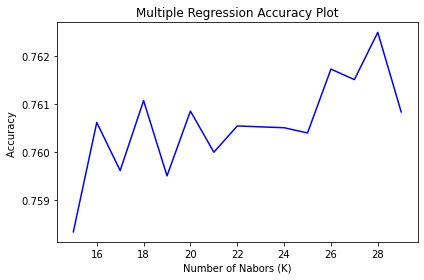

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

knum = list(range(15, 30))
err_val=[]

for k in knum:
    k_near = KNeighborsClassifier(n_neighbors = k)
    k_near.fit(x_train, y_train.flatten())
    err_val.append(metrics.accuracy_score(y_test, k_near.predict(x_test)))
    
plt.plot(knum, err_val, 'b')
plt.title("Multiple Regression Accuracy Plot")
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
#plt.show()
plt.savefig('KNN.jpg', bbox_inches = 'tight')

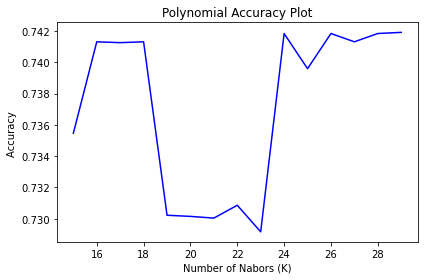

In [45]:
knum = list(range(15, 30))
err_val=[]

for k in knum:
    k_nearpoly = KNeighborsClassifier(n_neighbors = k)
    k_nearpoly.fit(xp_trainnew, y_train.flatten())
    err_val.append(metrics.accuracy_score(y_test, k_nearpoly.predict(xp_testnew)))
    
plt.plot(knum, err_val, 'b')
plt.title("Polynomial Accuracy Plot")
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
#plt.show()
plt.savefig('kNN_poly.jpg', bbox_inches = 'tight')

## Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier
desTree1 = DecisionTreeClassifier(criterion="entropy", max_depth = 20)
desTree2 = DecisionTreeClassifier(criterion="entropy", max_depth = 20)

desTree1.fit(x_train, y_train)
y_hat = desTree1.predict(x_test)

desTree2.fit(xp_train, y_train)
yp_hat = desTree2.predict(xp_test)

print('R2 in linear regression %.2f' % metrics.accuracy_score(y_test, y_hat))
print('R2 for polynomial features %.2f' % metrics.accuracy_score(y_test, yp_hat))

R2 in linear regression 0.76
R2 for polynomial features 0.76


## Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_similarity_score

In [48]:
LR1 = LogisticRegression(C=0.01, solver='liblinear').fit(x_train,y_train.flatten())
LR2 = LogisticRegression(C=0.01, solver='liblinear').fit(xp_train,y_train.flatten())

print('Linear regression %.2f' % jaccard_similarity_score(y_test, LR1.predict(x_test)))
print('Polynomial features %.2f' % jaccard_similarity_score(y_test, LR2.predict(xp_test)))

Linear regression 0.72
Polynomial features 0.75


# Model Evaluation <a name="ME"></a>

In [49]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

## Evaluation of linear features KNN classifier

In [50]:
print('Jaccard for KNN %.2f' % jaccard_similarity_score(y_test, k_near.predict(x_test)))
print('Jaccard for DecisionTree %.2f' % jaccard_similarity_score(y_test, desTree1.predict(x_test)))
print('Jaccard for logit %.2f' % jaccard_similarity_score(y_test, LR1.predict(x_test)))

Jaccard for KNN 0.76
Jaccard for DecisionTree 0.76
Jaccard for logit 0.72


In [51]:
print ('f1 score for KNN %.2f' % f1_score(y_test, k_near.predict(x_test), average='weighted'))
print ('f1 score for Decision Tree %.2f' % f1_score(y_test, desTree1.predict(x_test), average='weighted'))
print ('f1 score for logit %.2f' % f1_score(y_test, LR1.predict(x_test), average='weighted'))

f1 score for KNN 0.75
f1 score for Decision Tree 0.74
f1 score for logit 0.68


In [52]:
print('log loss for logit is %.2f' % log_loss(y_test, LR1.predict_proba(x_test)))

log loss for logit is 0.55


## Evaluation of polynomial features KNN classifier

In [53]:
print('Jaccard for KNN %.2f' % jaccard_similarity_score(y_test, k_nearpoly.predict(xp_testnew)))
print('Jaccard for DecisionTree %.2f' % jaccard_similarity_score(y_test, desTree2.predict(xp_test)))
print('Jaccard for logit %.2f' % jaccard_similarity_score(y_test, LR2.predict(xp_test)))

Jaccard for KNN 0.74
Jaccard for DecisionTree 0.76
Jaccard for logit 0.75


In [54]:
print ('f1 score for KNN %.2f' % f1_score(y_test, k_nearpoly.predict(xp_testnew), average='weighted'))
print ('f1 score for Decision Tree %.2f' % f1_score(y_test, desTree2.predict(xp_test), average='weighted'))
print ('f1 score for logit %.2f' % f1_score(y_test, LR2.predict(xp_test), average='weighted'))

f1 score for KNN 0.68
f1 score for Decision Tree 0.74
f1 score for logit 0.71


In [55]:
print('log loss for logit is %.2f' % log_loss(y_test, LR2.predict_proba(xp_test)))

log loss for logit is 0.50


## Report 

| Algorithm            | Jaccard  | F1-score | LogLoss |
|----------------------|----------|----------|---------|
| **KNN** **(Linear)** | **0.76** | **0.75** | **NA**  |
|                (Poly)| 0.74     | 0.68     | NA      |
| Decision Tree(Linear)| 0.76     | 0.74     | NA      |
|              (Poly)  | 0.76     | 0.74     | NA      |
| Logistic     (Linear)| 0.72     | 0.68     | 0.55    |
|               (Poly) | 0.75     | 0.71     | 0.50    |

# Discussion <a name="discuss"></a>

The research provides some insights into the predictors of the severity of car accidents. The data exploration shows that most accidents in Seattle occur in clear weather conditions. Majority of the accidents occurred at night in the dark and the absence of street lights. The accident in dark streets happen more when drivers are speeding and under the influence of psychoactive substances. Drivers speeding under the influence of drugs in a dark street contributes substantially to the occurrence of accidents that cause injury.

The research also created a model that predicts car accidents severity using the available features collected from the SDOT dataset. The machine learning model that best predicts accident severity is the K-Nearest Neighbour with K=20 and linear features which excludes interaction effects.

# Policy Recommendation <a name="policy"></a>
From the discussion and the results, I give the following recommendations to the government. First, they need to provide street lights in prominent roads as the absence of light on the streets seem to co-occur with the incident of vehicular accidents in general. Also the government should inform the public on the dangers of speeding and using psychoactive substances while driving. An increase in fines and the number of law enforcement officers checking driver's state of consciousness while driving will help decrease these risky behaviour on the streets of Seattle.